# WIDS-SAP-case-comp
**DebugDynamos**

In [43]:
library(tidyverse)
install.packages("repr")
library(repr)
install.packages("car")
library(car)
library(ggplot2)
library(gridExtra)
install.packages("rpart", dependencies = TRUE)
library(rpart)
install.packages("rpart.plot")
library(rpart.plot)
install.packages("caret")
library(caret)
install.packages("ResourceSelection")
library(ResourceSelection)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Warning message in install.packages("rpart", dependencies = TRUE):
“installation of package ‘rpart’ had non-zero exit status”
Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [301]:
train_data <- read.csv("data/train.csv")
test_data <- read.csv("data/test.csv")
head(train_data)

,ID,Age,AI_Interaction_Level,Satisfaction_with_AI_Services,AI_Personalization_Effectiveness,AI_Response_Time,Overall_Usage_Frequency,Customer_Service_Interactions,Change_in_Usage_Patterns,Customer_Churn
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,59,2,7,7,2,18,5,2,1
2,2,49,2,6,5,1,3,2,0,0
3,3,35,2,3,3,3,8,2,1,1
4,4,63,2,3,3,2,6,6,2,1
5,5,28,4,6,6,1,11,3,-1,0
6,6,41,3,1,1,3,28,2,-1,0


First, out of curiosity, let's explore graphically how the customer churn appears to depend on age

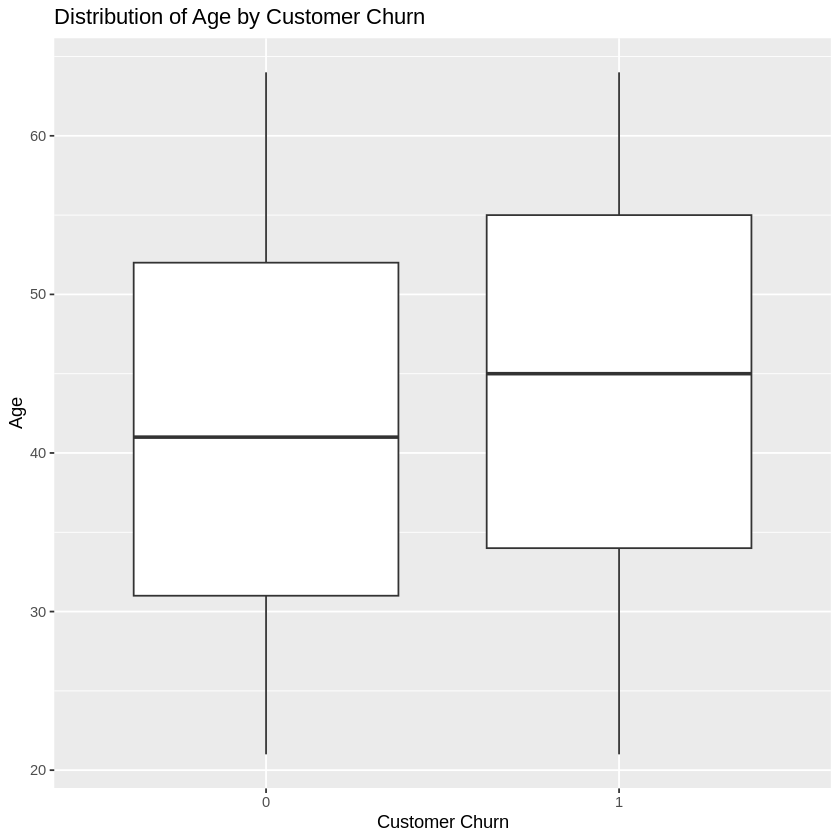

In [302]:
ggplot(train_data, aes(x = as.factor(Customer_Churn), y = Age)) + 
  geom_boxplot() + 
  xlab("Customer Churn") + 
  ylab("Age") + 
  ggtitle("Distribution of Age by Customer Churn")

Roughly speak, elder people are more likely to churn under the impact of AI

Then, explore graphically the relationship between the Customer_Churn and AI_Interaction_Level/Satisfaction_with_AI_Services

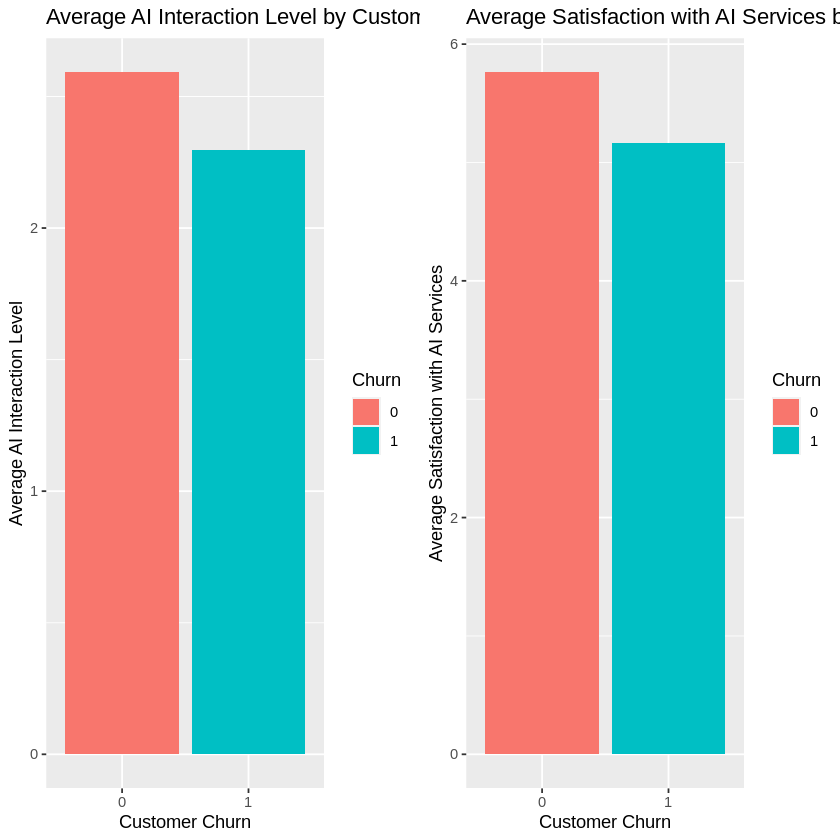

In [303]:
# Bar Plot for AI_Interaction_Level
bar_churn_inter <-
    ggplot(train_data, aes(x = as.factor(Customer_Churn), y = AI_Interaction_Level, fill = as.factor(Customer_Churn))) + 
      geom_bar(stat = "summary", fun = "mean") +
      labs(x = "Customer Churn", y = "Average AI Interaction Level", fill = "Churn") +
      ggtitle("Average AI Interaction Level by Customer Churn")

# Bar Plot for Satisfaction_with_AI_Services
bar_churn_satis <-
    ggplot(train_data, aes(x = as.factor(Customer_Churn), y = Satisfaction_with_AI_Services, fill = as.factor(Customer_Churn))) + 
      geom_bar(stat = "summary" , fun = "mean") +
      labs(x = "Customer Churn", y = "Average Satisfaction with AI Services", fill = "Churn") +
      ggtitle("Average Satisfaction with AI Services by Customer Churn")
grid.arrange(bar_churn_inter, bar_churn_satis, ncol=2)

From the grph, we know that people with lower average AI interaction level and lower average satisfaction with AI services tend to churn.

## Fit the logistic regression model

now, we start to fit the model using the training data.

In [304]:
model <- glm(Customer_Churn ~ Age + AI_Interaction_Level + Satisfaction_with_AI_Services +
             AI_Personalization_Effectiveness + AI_Response_Time + Overall_Usage_Frequency +
             Customer_Service_Interactions + Change_in_Usage_Patterns,
             data = train_data, family = binomial)
summary(model)


Call:
glm(formula = Customer_Churn ~ Age + AI_Interaction_Level + Satisfaction_with_AI_Services + 
    AI_Personalization_Effectiveness + AI_Response_Time + Overall_Usage_Frequency + 
    Customer_Service_Interactions + Change_in_Usage_Patterns, 
    family = binomial, data = train_data)

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       1.490312   0.299814   4.971 6.67e-07 ***
Age                              -0.006199   0.003810  -1.627   0.1037    
AI_Interaction_Level             -0.411633   0.051462  -7.999 1.26e-15 ***
Satisfaction_with_AI_Services    -0.087719   0.038145  -2.300   0.0215 *  
AI_Personalization_Effectiveness  0.010874   0.037867   0.287   0.7740    
AI_Response_Time                 -0.040143   0.035838  -1.120   0.2627    
Overall_Usage_Frequency          -0.004403   0.003358  -1.311   0.1898    
Customer_Service_Interactions     0.003600   0.009187   0.392   0.6952    
Change_in_Usage_Patt

Set the significance level to 0.05, so in the model above, most variables are not significant, except AI_Interaction_Level and Satisfaction_with_AI_Services.
Variables not significantly associated with the outcome might be candidates for removal from the model, but as some variables might be important for theoretical or business reasons despite their statistical significance, we decide to improve our model by incorporating quadratic terms (squared variables) and centering the predictors.

Center the variables to improve the collinearity which is a possible problem following the use of quadratic terms.

In [369]:
# Centering the variables
train_centered <- train_data |>
    mutate(Age = Age - mean(Age),
           AI_Personalization_Effectiveness = AI_Personalization_Effectiveness - mean(AI_Personalization_Effectiveness),
           AI_Response_Time = AI_Response_Time - mean(AI_Response_Time),
           Overall_Usage_Frequency = Overall_Usage_Frequency - mean(Overall_Usage_Frequency),
           Customer_Service_Interactions = Customer_Service_Interactions - mean(Customer_Service_Interactions),
           Change_in_Usage_Patterns = Change_in_Usage_Patterns - mean(Change_in_Usage_Patterns))

model_2 <- glm(Customer_Churn ~ Age + I(Age^2) + AI_Interaction_Level + Satisfaction_with_AI_Services +
             AI_Personalization_Effectiveness + I(AI_Personalization_Effectiveness^2) + AI_Response_Time + 
             I(AI_Response_Time^2) + Overall_Usage_Frequency + I(Overall_Usage_Frequency^2) + 
             Customer_Service_Interactions + I(Customer_Service_Interactions^2) + 
             Change_in_Usage_Patterns + I(Change_in_Usage_Patterns^2),
             data = train_centered, family = binomial)
summary(model_2)


Call:
glm(formula = Customer_Churn ~ Age + I(Age^2) + AI_Interaction_Level + 
    Satisfaction_with_AI_Services + AI_Personalization_Effectiveness + 
    I(AI_Personalization_Effectiveness^2) + AI_Response_Time + 
    I(AI_Response_Time^2) + Overall_Usage_Frequency + I(Overall_Usage_Frequency^2) + 
    Customer_Service_Interactions + I(Customer_Service_Interactions^2) + 
    Change_in_Usage_Patterns + I(Change_in_Usage_Patterns^2), 
    family = binomial, data = train_centered)

Coefficients:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                            1.0913041  0.2648493   4.120 3.78e-05
Age                                   -0.0059567  0.0038162  -1.561  0.11855
I(Age^2)                               0.0002108  0.0002048   1.029  0.30340
AI_Interaction_Level                  -0.4105876  0.0516195  -7.954 1.80e-15
Satisfaction_with_AI_Services         -0.0847865  0.0382651  -2.216  0.02671
AI_Personalization_Effectiveness       

In [370]:
vif_values <- vif(model_2)
vif_values

Age                              I(Age^2) 
                             2.671676                              1.002757 
                 AI_Interaction_Level         Satisfaction_with_AI_Services 
                             2.676443                             14.001939 
     AI_Personalization_Effectiveness I(AI_Personalization_Effectiveness^2) 
                            13.995841                              1.004667 
                     AI_Response_Time                 I(AI_Response_Time^2) 
                             1.004050                              1.003740 
              Overall_Usage_Frequency          I(Overall_Usage_Frequency^2) 
                             1.001256                              1.002420 
        Customer_Service_Interactions    I(Customer_Service_Interactions^2) 
                             1.003092                              1.003048 
             Change_in_Usage_Patterns         I(Change_in_Usage_Patterns^2) 
                             1.002949                              1.001898

Most vif values are smaller than 5, except the vif value for Satisfaction_with_AI_Services(14.0019386891924) and 
AI_Personalization_Effectiveness(13.9958411237634). Thus, there exists a strong collinearity between these two variables. 

To deal with this problem, we implement the `PCA` to reduce the dimensionality of the data, taking the first principal 
component of the two variables as a new predictor, which will be a linear combination of them that captures the maximum variance.

In [371]:
library(stats)
# Scale the variables
scaled_data <- scale(train_data[, c("Satisfaction_with_AI_Services", "AI_Personalization_Effectiveness")])
# Perform PCA
pca_result <- prcomp(scaled_data)

# Examine the summary of the PCA result
summary(pca_result)

Importance of components:
                          PC1     PC2
Standard deviation     1.4013 0.19086
Proportion of Variance 0.9818 0.01821
Cumulative Proportion  0.9818 1.00000

From the summary, almost all of the variability in the two original variables can be effectively summarized by the first principal component (PC1). The second principal component (PC2) captures a very small amount of additional variance and is likely not necessary if we're looking to reduce dimensionality without significant loss of information.

Thus, we choose to use only the first principal component as a predictor in your logistic regression model to represent the combined effect of the original variables, without significant loss of information.

In [372]:
# Create a new variable in the original dataset based on the first principal component
train_centered$PCA_1 <- pca_result$x[, 1]

**Now, fit the model again**

In [309]:
model_3 <- glm(Customer_Churn ~ Age + I(Age^2) + AI_Interaction_Level + PCA_1 +
             AI_Response_Time + 
             I(AI_Response_Time^2) + Overall_Usage_Frequency + I(Overall_Usage_Frequency^2) + 
             Customer_Service_Interactions + I(Customer_Service_Interactions^2) + 
             Change_in_Usage_Patterns + I(Change_in_Usage_Patterns^2),
             data = train_centered, family = binomial)
summary(model_3)


Call:
glm(formula = Customer_Churn ~ Age + I(Age^2) + AI_Interaction_Level + 
    PCA_1 + AI_Response_Time + I(AI_Response_Time^2) + Overall_Usage_Frequency + 
    I(Overall_Usage_Frequency^2) + Customer_Service_Interactions + 
    I(Customer_Service_Interactions^2) + Change_in_Usage_Patterns + 
    I(Change_in_Usage_Patterns^2), family = binomial, data = train_centered)

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         0.6933497  0.1520638   4.560 5.13e-06 ***
Age                                -0.0060605  0.0038118  -1.590  0.11185    
I(Age^2)                            0.0002106  0.0002047   1.029  0.30357    
AI_Interaction_Level               -0.4121063  0.0515722  -7.991 1.34e-15 ***
PCA_1                               0.1547703  0.0210062   7.368 1.73e-13 ***
AI_Response_Time                   -0.0371838  0.0359981  -1.033  0.30163    
I(AI_Response_Time^2)              -0.0924361  0.0619070  -1.493

Dealing with the problem of insignificant variables, in the context of customer churn and AI services, we considered to include some plausible interactions.
* Age & AI Interaction Level
* AI_Response_Time & PCA_1 
* Overall Usage Frequency & Change in Usage Patterns
* Customer Service Interactions & Change in Usage Patterns
* Overall_Usage_Frequency & PCA_1

In [310]:
model_interaction <- glm(Customer_Churn ~ Age * AI_Interaction_Level + I(Age^2) +
                         AI_Response_Time * PCA_1 * Overall_Usage_Frequency + 
                         I(AI_Response_Time^2) +  I(Overall_Usage_Frequency^2) + 
                         I(Customer_Service_Interactions^2) + I(Change_in_Usage_Patterns^2) +
                         Change_in_Usage_Patterns * Customer_Service_Interactions ,
                         data = train_centered, family = binomial)
summary(model_interaction)


Call:
glm(formula = Customer_Churn ~ Age * AI_Interaction_Level + I(Age^2) + 
    AI_Response_Time * PCA_1 * Overall_Usage_Frequency + I(AI_Response_Time^2) + 
    I(Overall_Usage_Frequency^2) + I(Customer_Service_Interactions^2) + 
    I(Change_in_Usage_Patterns^2) + Change_in_Usage_Patterns * 
    Customer_Service_Interactions, family = binomial, data = train_centered)

Coefficients:
                                                         Estimate Std. Error
(Intercept)                                             0.6933199  0.1526282
Age                                                    -0.0031270  0.0114462
AI_Interaction_Level                                   -0.4127974  0.0516437
I(Age^2)                                                0.0001489  0.0002971
AI_Response_Time                                       -0.0352632  0.0360812
PCA_1                                                   0.1550499  0.0210234
Overall_Usage_Frequency                                -0.0042147  0.00

Now, remove the interactions which have quite large p-value(insignificant).

In [311]:
model_inter <- glm(Customer_Churn ~ Age + AI_Interaction_Level + I(Age^2) +
                         AI_Response_Time + PCA_1 * Overall_Usage_Frequency + 
                         I(AI_Response_Time^2) +  
                         I(Customer_Service_Interactions^2) + I(Change_in_Usage_Patterns^2) +
                         Change_in_Usage_Patterns + Customer_Service_Interactions ,
                         data = train_centered, family = binomial)
summary(model_inter)


Call:
glm(formula = Customer_Churn ~ Age + AI_Interaction_Level + I(Age^2) + 
    AI_Response_Time + PCA_1 * Overall_Usage_Frequency + I(AI_Response_Time^2) + 
    I(Customer_Service_Interactions^2) + I(Change_in_Usage_Patterns^2) + 
    Change_in_Usage_Patterns + Customer_Service_Interactions, 
    family = binomial, data = train_centered)

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         0.6707705  0.1484718   4.518 6.25e-06 ***
Age                                -0.0060562  0.0038120  -1.589  0.11213    
AI_Interaction_Level               -0.4125722  0.0515816  -7.998 1.26e-15 ***
I(Age^2)                            0.0002129  0.0002047   1.040  0.29826    
AI_Response_Time                   -0.0376562  0.0360041  -1.046  0.29561    
PCA_1                               0.1543997  0.0210118   7.348 2.01e-13 ***
Overall_Usage_Frequency            -0.0042158  0.0033664  -1.252  0.21045    
I(AI_Response_Tim

Given the p-value for I(Customer_Service_Interactions^2) is pretty low compared to that of Customer_Service_Interactions,
let's create a model without the variable Customer_Service_Interactions and do the anova test to compare.

In [312]:
model_reduced <- glm(Customer_Churn ~  Age + AI_Interaction_Level + I(Age^2) +
                         AI_Response_Time + PCA_1 * Overall_Usage_Frequency + 
                         I(AI_Response_Time^2) +  
                         I(Customer_Service_Interactions^2) + I(Change_in_Usage_Patterns^2) +
                         Change_in_Usage_Patterns ,
                     data = train_centered, family = binomial)
anova(model_reduced, model_inter, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4988,6598.754,NA,NA,NA
2,4987,6598.521,1,0.2336702,0.6288157


The reduced model (model 2) has 1 fewer degrees of freedom than the full model (model 1), and the deviance has increased by 0.2336702. The p-value of 0.6288157 suggests that the difference in deviance is not statistically significant at common alpha levels (like 0.05), which implies that the simpler model without the main effect term of Customer_Service_Interactions is not significantly worse than the full model. This could mean that including the main effect of Customer_Service_Interactions is not necessary when the squared term and the interaction term are present in the model. Hence, we decide to delete the variable 
Customer_Service_Interactions.

In [313]:
summary(model_reduced)


Call:
glm(formula = Customer_Churn ~ Age + AI_Interaction_Level + I(Age^2) + 
    AI_Response_Time + PCA_1 * Overall_Usage_Frequency + I(AI_Response_Time^2) + 
    I(Customer_Service_Interactions^2) + I(Change_in_Usage_Patterns^2) + 
    Change_in_Usage_Patterns, family = binomial, data = train_centered)

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         0.6726716  0.1484231   4.532 5.84e-06 ***
Age                                -0.0060896  0.0038113  -1.598  0.11009    
AI_Interaction_Level               -0.4128799  0.0515773  -8.005 1.19e-15 ***
I(Age^2)                            0.0002105  0.0002046   1.029  0.30360    
AI_Response_Time                   -0.0373632  0.0359980  -1.038  0.29930    
PCA_1                               0.1542680  0.0210095   7.343 2.09e-13 ***
Overall_Usage_Frequency            -0.0042034  0.0033662  -1.249  0.21177    
I(AI_Response_Time^2)              -0.0938913  0.06191

**Do the same anova test on Age and I(Age^2)**

In [314]:
model_no_age2 <- glm(Customer_Churn ~  Age + AI_Interaction_Level + 
                         AI_Response_Time + PCA_1 * Overall_Usage_Frequency + 
                         I(AI_Response_Time^2) +  
                         I(Customer_Service_Interactions^2) + I(Change_in_Usage_Patterns^2) +
                         Change_in_Usage_Patterns ,
                     data = train_centered, family = binomial)
anova(model_no_age2, model_reduced, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4989,6599.812,NA,NA,NA
2,4988,6598.754,1,1.057411,0.3038065


The p-value 0.3038065 shows that the subtraction of I(Age^2) doesn't significantly make the model worse, so we choose to delete it.

In [315]:
summary(model_no_age2)


Call:
glm(formula = Customer_Churn ~ Age + AI_Interaction_Level + AI_Response_Time + 
    PCA_1 * Overall_Usage_Frequency + I(AI_Response_Time^2) + 
    I(Customer_Service_Interactions^2) + I(Change_in_Usage_Patterns^2) + 
    Change_in_Usage_Patterns, family = binomial, data = train_centered)

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         0.702379   0.145596   4.824 1.41e-06 ***
Age                                -0.006005   0.003814  -1.575  0.11537    
AI_Interaction_Level               -0.411369   0.051543  -7.981 1.45e-15 ***
AI_Response_Time                   -0.037596   0.035992  -1.045  0.29622    
PCA_1                               0.154756   0.021003   7.368 1.73e-13 ***
Overall_Usage_Frequency            -0.004253   0.003365  -1.264  0.20627    
I(AI_Response_Time^2)              -0.093411   0.061902  -1.509  0.13130    
I(Customer_Service_Interactions^2)  0.008553   0.003296   2.595  0.00947 

#### Model Diagnostics:
Conduct model diagnostics to check for influential observations (with high leverage or large residuals) that could be affecting the model fit.

In [316]:
cooks_d <- cooks.distance(model_no_age2)
# Find the indices of the values which are greater than 1
influential_points <- any(cooks_d > 1)
influential_points

[1] FALSE

There does not exist any "influential" points to be excluded.

In [317]:
vif_values <- vif(model_inter,type = "predictor")
vif_values

Warning message in vif.lm(model_inter, type = "predictor"):
“type = 'predictor' is available only for unweighted linear models;
  type = 'terms' will be used”


Age               AI_Interaction_Level 
                          2.668569                           2.674519 
                          I(Age^2)                   AI_Response_Time 
                          1.002629                           1.003096 
                             PCA_1            Overall_Usage_Frequency 
                          1.004518                           1.002929 
             I(AI_Response_Time^2) I(Customer_Service_Interactions^2) 
                          1.003225                           1.002518 
     I(Change_in_Usage_Patterns^2)           Change_in_Usage_Patterns 
                          1.001820                           1.001973 
     Customer_Service_Interactions      PCA_1:Overall_Usage_Frequency 
                          1.002875                           1.002646

All vif values look good(<5), suggesting no collinearity exist.

#### McFadden's R-squared

In [318]:
# Fit the null model
null_model <- glm(Customer_Churn ~ 1, data = train_centered, family = binomial)

# Extract log-likelihoods
logLik_full <- logLik(model_no_age2)
logLik_null <- logLik(null_model)

# Calculate McFadden's R-squared
mcfadden_r_squared <- 1 - (logLik_full/logLik_null)
mcfadden_r_squared

'log Lik.' 0.02901727 (df=11)

Given a very small McFadden's R-squared(very far from 1), meaning the worse fitting.

In [319]:
churn_numeric <- as.numeric(as.character(train_centered$Customer_Churn)) - 1
# Get the predicted probabilities
predicted_probs <- fitted(model_no_age2)
# Perform the Hosmer-Lemeshow goodness of fit test
hoslem_test_result <- hoslem.test(churn_numeric, predicted_probs)
hoslem_test_result


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  churn_numeric, predicted_probs
X-squared = 21630, df = 8, p-value < 2.2e-16


#### Comment
It seems that the simple logistic regression isn't capturing the relationships in our data well, so we decide to try other modeling approaches that can handle complex interactions and non-linear relationships, such as tree-based methods.

### Create tree model

In [320]:
tree_model <- rpart(Customer_Churn ~  Age + AI_Interaction_Level + 
                         AI_Response_Time + PCA_1 + 
                         I(AI_Response_Time^2) +  
                         I(Customer_Service_Interactions^2) + I(Change_in_Usage_Patterns^2) +
                         Change_in_Usage_Patterns + Overall_Usage_Frequency ,
                    data = train_centered, 
                    method = "class")


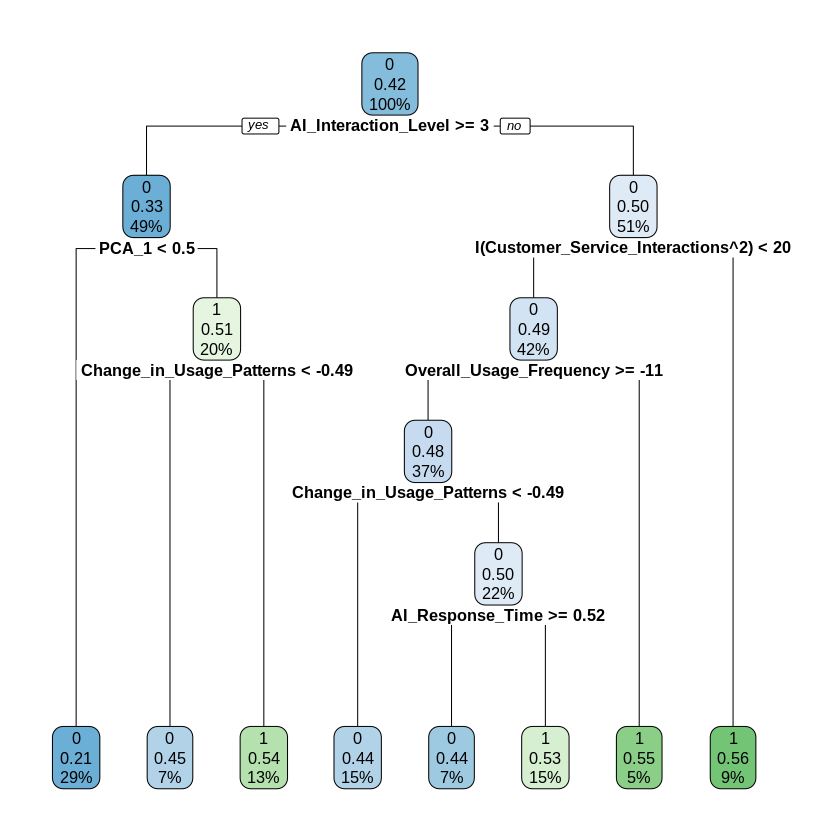

In [321]:
rpart.plot(tree_model)

In [322]:
optimal_cp <- tree_model$cptable[which.min(tree_model$cptable[,"xerror"]), "CP"]
optimal_cp

[1] 0.01362984

In [323]:
# Ensure the column names used match those in the training data
columns_to_scale <- c("Satisfaction_with_AI_Services", "AI_Personalization_Effectiveness")

# Scale the test data using the center and scale of the training data obtained during PCA
scaled_test_data <- scale(test_data[, columns_to_scale], 
                          center = pca_result$center, 
                          scale = pca_result$scale)

# Apply PCA transformation to the test data
test_data_PCA <- predict(pca_result, newdata = scaled_test_data)

# Add the first principal component to your test data
test_data$PCA_1 <- test_data_PCA[, 1]


In [324]:
prediction <- predict(tree_model, newdata = test_data, type = "class")
confusion_matrix <- table(test_data$Customer_Churn, prediction)
print(confusion_matrix)


   prediction
      0   1
  0 537 177
  1 335 201


In [325]:
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
accuracy

[1] 0.5904

To get a more accurate estimation of our model's performance, consider performing cross-validation.

In [326]:
nrow(train_data)

[1] 5000

In [327]:
set.seed(4503)
train_centered$Customer_Churn <- factor(train_centered$Customer_Churn, levels = c("0", "1"))
# Define train control
train_control <- trainControl(method = "cv", number = 50)

# Train the model with cross-validation
cv_model <- train(Customer_Churn ~  Age + AI_Interaction_Level + 
                         AI_Response_Time + PCA_1 + 
                         I(AI_Response_Time^2) +  
                         I(Customer_Service_Interactions^2) + I(Change_in_Usage_Patterns^2) +
                         Change_in_Usage_Patterns + Overall_Usage_Frequency ,
                  data = train_centered, method = "rpart",
                  trControl = train_control)

# Access cross-validated results
print(cv_model)

CART 

5000 samples
   7 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (50 fold) 
Summary of sample sizes: 4900, 4901, 4900, 4900, 4901, 4900, ... 
Resampling results across tuning parameters:

  cp          Accuracy   Kappa     
  0.01123864  0.5838388  0.08462075
  0.01291248  0.5810346  0.05826208
  0.01362984  0.5740245  0.02204784

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.01123864.


In [328]:
prediction_cv <- predict(cv_model, newdata = test_data, type = "raw")
confusion_matrix_cv <- table(test_data$Customer_Churn, prediction_cv)
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix_cv)
accuracy


[1] 0.5904

In [329]:
print(cv_model$bestTune)

# For the rpart model (this will show you the cp value used if you didn't set it manually)
printcp(tree_model)

          cp
1 0.01123864

Classification tree:
rpart(formula = Customer_Churn ~ Age + AI_Interaction_Level + 
    AI_Response_Time + PCA_1 + I(AI_Response_Time^2) + I(Customer_Service_Interactions^2) + 
    I(Change_in_Usage_Patterns^2) + Change_in_Usage_Patterns + 
    Overall_Usage_Frequency, data = train_centered, method = "class")

Variables actually used in tree construction:
[1] AI_Interaction_Level               AI_Response_Time                  
[3] Change_in_Usage_Patterns           I(Customer_Service_Interactions^2)
[5] Overall_Usage_Frequency            PCA_1                             

Root node error: 2091/5000 = 0.4182

n= 5000 

        CP nsplit rel error xerror     xstd
1 0.013630      0   1.00000 1.0000 0.016681
2 0.012912      2   0.97274 1.0320 0.016749
3 0.011239      3   0.95983 1.0340 0.016753
4 0.010282      5   0.93735 1.0172 0.016719
5 0.010000      7   0.91679 1.0182 0.016721


#### Train a RandomForest Model:

In [330]:
install.packages("randomForest")
library(randomForest)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



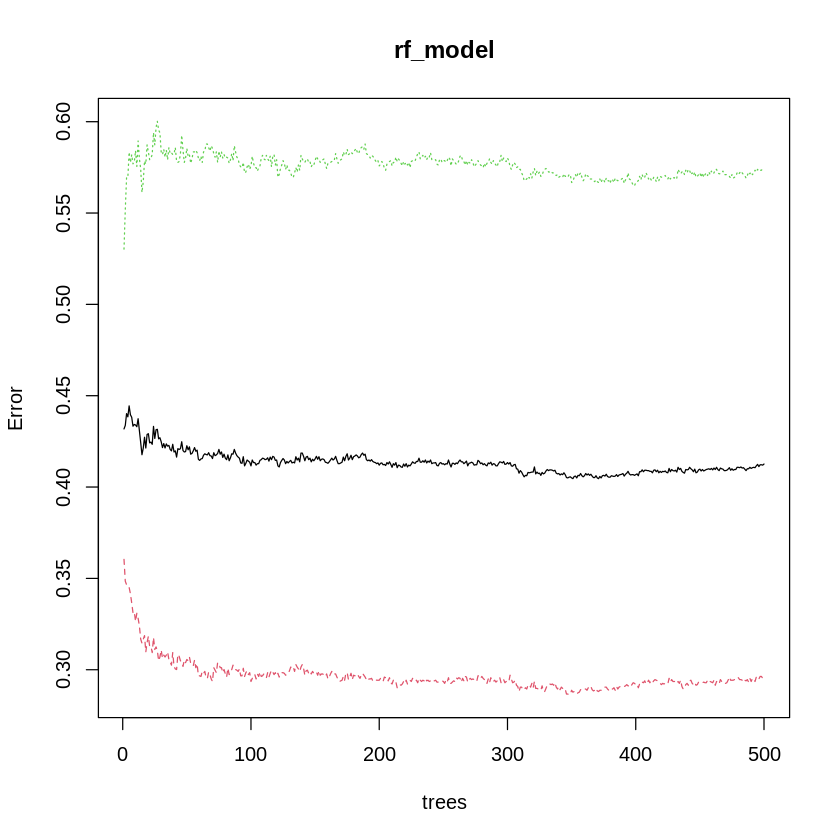

In [331]:
set.seed(4503)  # For reproducibility

rf_model <- randomForest(Customer_Churn ~ Age + AI_Interaction_Level + 
                         AI_Response_Time + PCA_1 + Customer_Service_Interactions +
                         I(AI_Response_Time^2) +  
                         I(Customer_Service_Interactions^2) + I(Change_in_Usage_Patterns^2) +
                         Change_in_Usage_Patterns + Overall_Usage_Frequency , 
                         data=train_centered, ntree=500, mtry=3)
# visualize the error rates as more trees are added
plot(rf_model)

#### Fine-Tuning:

mtry = 3  OOB error = 42.28% 
Searching left ...
mtry = 6 	OOB error = 42.96% 
-0.01608325 0.01 
Searching right ...
mtry = 1 	OOB error = 42.74% 
-0.01087985 0.01 


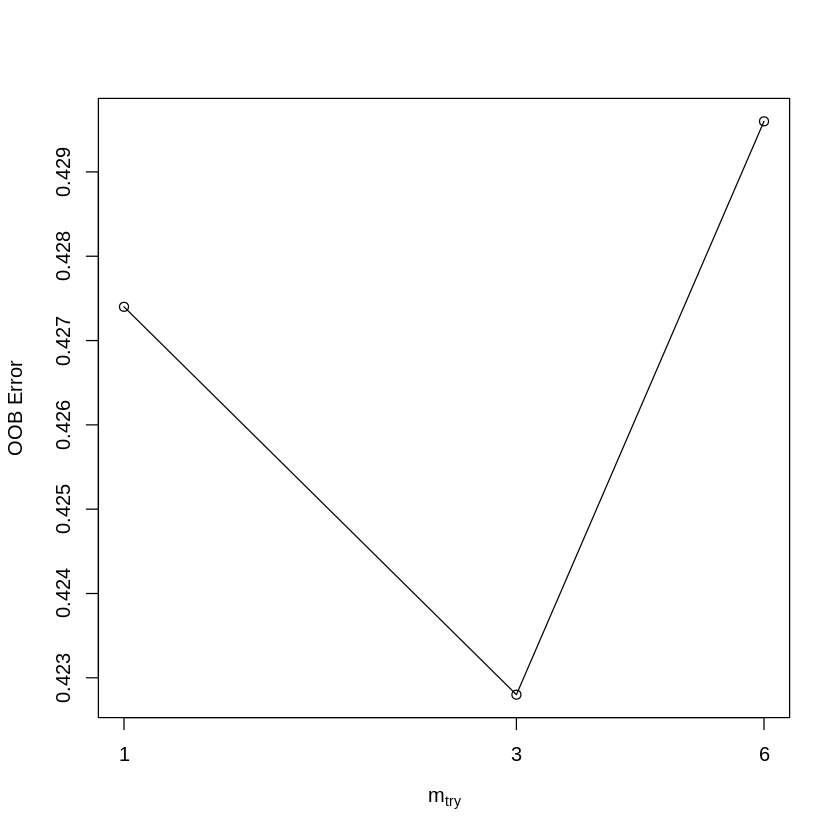

In [332]:
tuned_rf_model <- tuneRF(train_centered[, -which(names(train_centered) == "Customer_Churn")],
                         train_centered$Customer_Churn,
                         stepFactor=0.5,
                         improve=0.01,
                         ntreeTry=500,
                         trace=TRUE,
                         plot=TRUE)


In this case, based on the plot, the optimal value of mtry for this particular random forest model seems to be 3, as it gives the lowest OOB error rate, meaning the model has the best generalization performance with this parameter setting.

#### Further investigation(fine-tune the model)

In [333]:
mtry_values <- 3:10
oob_errors <- numeric(length(mtry_values))

# Train a random forest model for each mtry value and record the OOB error
for (i in seq_along(mtry_values)) {
  rf_model <- randomForest(Customer_Churn ~ ., data = train_centered, mtry = mtry_values[i], ntree = 500)
  oob_errors[i] <- rf_model$err.rate[500, "OOB"]
}

# Combine the mtry values and their corresponding OOB errors
tuning_results <- data.frame(mtry = mtry_values, OOB_Error = oob_errors)
tuning_results

mtry,OOB_Error
<int>,<dbl>
3,0.4312
4,0.4306
5,0.4292
6,0.4280
7,0.4274
8,0.4304
9,0.4284
10,0.4278


In [334]:
# Find the mtry value with the lowest OOB error
best_mtry <- tuning_results$mtry[which.min(tuning_results$OOB_Error)]
best_oob_error <- min(tuning_results$OOB_Error)

# Print the best mtry value and the corresponding OOB error
cat("Best mtry value:", best_mtry, "with OOB error:", best_oob_error, "\n")


Best mtry value: 7 with OOB error: 0.4274 


#### Train the random forest model using the best mtry value

In [335]:
rf_best_model <- randomForest(Customer_Churn ~ Age + AI_Interaction_Level + 
                         AI_Response_Time + PCA_1 + Customer_Service_Interactions +
                         I(AI_Response_Time^2) +  
                         I(Customer_Service_Interactions^2) + I(Change_in_Usage_Patterns^2) +
                         Change_in_Usage_Patterns + Overall_Usage_Frequency , data = train_centered, mtry = 9, ntree = 500)

# Make predictions on the test set
test_predictions <- predict(rf_best_model, newdata = test_data)

# Assuming the actual test set labels are in test_data$Customer_Churn
# Calculate the confusion matrix
confusion_matrix <- table(test_data$Customer_Churn, test_predictions)

# Calculate accuracy
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)

# Print the confusion matrix and accuracy
print(confusion_matrix)
print(paste("Accuracy:", accuracy))


   test_predictions
      0   1
  0 477 237
  1 268 268
[1] "Accuracy: 0.596"


#### more detailed performance analysis

In [336]:
suppressPackageStartupMessages(library(pROC))

test_probabilities <- predict(rf_best_model, newdata = test_data, type = "prob")[, "1"]

# Calculate ROC and AUC
roc_result <- roc(test_data$Customer_Churn, test_probabilities)
auc_value <- auc(roc_result)

# Print the AUC value
print(paste("AUC:", auc_value))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC: 0.611051883439943"


AUC: 0.616 suggests that our model has a modest ability to discriminate between the classes, performing better than random guessing but far from perfect.

#### Create dummy variables

In [344]:
levels(train_centered$AI_Response_Time)


[1] "-0.9816" "0.0184"  "1.0184"

In [373]:
# Make sure AI_Interaction_Level is a factor with correct levels and labels
train_centered$AI_Interaction_Level <- as.factor(train_centered$AI_Interaction_Level)
train_centered$AI_Response_Time <- factor(train_centered$AI_Response_Time,
                                         levels = c(-0.9816, 0.0184, 1.0184),
                                         labels = c("1", "2", "3"))
dummy_AIL <- model.matrix(~ AI_Interaction_Level - 1, data=train_centered)
dummy_ART <- model.matrix(~ AI_Response_Time - 1, data=train_centered)
# Convert matrices to data frames
dummy_AIL_df <- as.data.frame(dummy_AIL)
dummy_ART_df <- as.data.frame(dummy_ART)
names(dummy_AIL_df) <- make.names(names(dummy_AIL_df))
names(dummy_ART_df) <- make.names(names(dummy_ART_df))

# Combine the dummy variables with the original dataset (excluding the original factor variables)
train_transformed <- cbind(train_centered[, !(names(train_centered) %in% c("AI_Interaction_Level", "AI_Response_Time"))],
                           dummy_AIL_df, dummy_ART_df)
names(train_transformed) <- make.names(names(train_transformed))

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


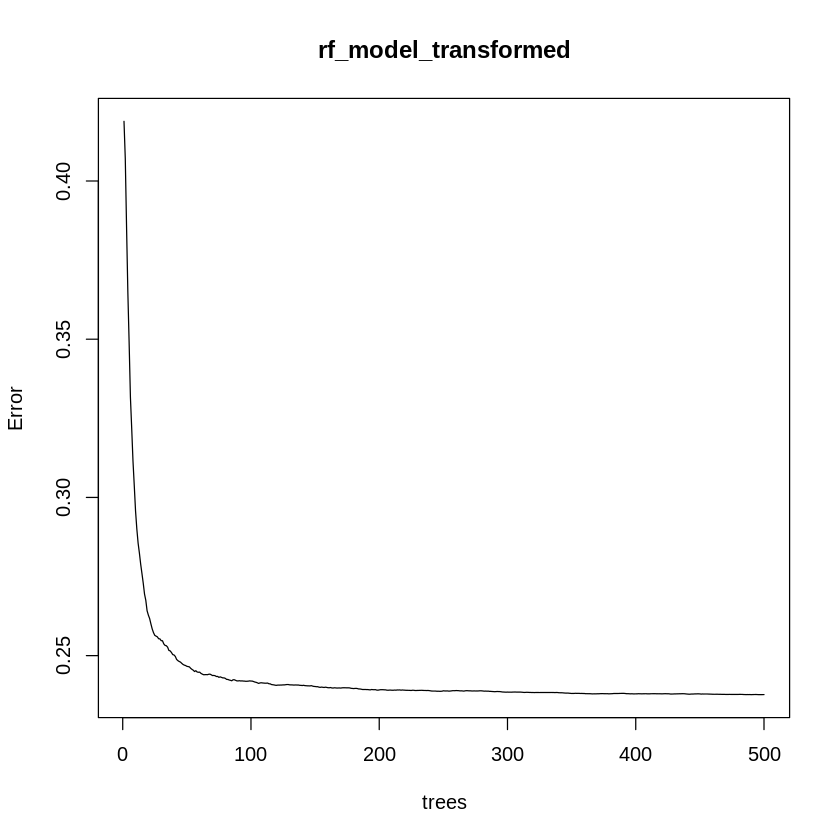

In [376]:
set.seed(4503)  

rf_model_transformed <- randomForest(Customer_Churn ~ ., 
                                     data=train_transformed, 
                                     ntree=500, 
                                     mtry=9)

# Visualize the error rates as more trees are added
plot(rf_model_transformed)

In [374]:
# Assume dummy_AIL and dummy_ART have been transformed the same way for the test data
# Creating dummy variables for the test set, just like the training set

test_data$AI_Interaction_Level <- as.factor(test_data$AI_Interaction_Level)
test_data$AI_Response_Time <- as.factor(test_data$AI_Response_Time)
dummy_AIL_test <- model.matrix(~ AI_Interaction_Level - 1, data=test_data)
dummy_ART_test <- model.matrix(~ AI_Response_Time - 1, data=test_data)

# Convert to data frames and ensure names match those in train_transformed
dummy_AIL_test_df <- as.data.frame(dummy_AIL_test)
names(dummy_AIL_test_df) <- make.names(names(dummy_AIL_test_df))
dummy_ART_test_df <- as.data.frame(dummy_ART_test)
names(dummy_ART_test_df) <- make.names(names(dummy_ART_test_df))

# Combine with other test data (excluding original categorical variables)
test_transformed <- cbind(test_data[, !(names(test_data) %in% c("AI_Interaction_Level", "AI_Response_Time"))], dummy_AIL_test_df, dummy_ART_test_df)
head(train_transformed)
head(test_transformed)

,ID,Age,Satisfaction_with_AI_Services,AI_Personalization_Effectiveness,Overall_Usage_Frequency,Customer_Service_Interactions,Change_in_Usage_Patterns,Customer_Churn,PCA_1,AI_Interaction_Level1,AI_Interaction_Level2,AI_Interaction_Level3,AI_Interaction_Level4,AI_Response_Time1,AI_Response_Time2,AI_Response_Time3
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,16.425,7,1.4742,2.485,-0.0662,2.005,1,-0.729098306,0,1,0,0,0,1,0
2,2,6.425,6,-0.5258,-12.515,-3.0662,0.005,0,0.008100349,0,1,0,0,1,0,0
3,3,-7.575,3,-2.5258,-7.515,-3.0662,1.005,1,1.239009432,0,1,0,0,0,0,1
4,4,20.425,3,-2.5258,-9.515,0.9338,2.005,1,1.239009432,0,1,0,0,0,1,0
5,5,-14.575,6,0.4742,-4.515,-2.0662,-0.995,0,-0.237071372,0,0,0,1,1,0,0
6,6,-1.575,1,-4.5258,12.485,-3.0662,-0.995,0,2.223063301,0,0,1,0,0,0,1


,ID,Age,Satisfaction_with_AI_Services,AI_Personalization_Effectiveness,Overall_Usage_Frequency,Customer_Service_Interactions,Change_in_Usage_Patterns,Customer_Churn,PCA_1,AI_Interaction_Level1,AI_Interaction_Level2,AI_Interaction_Level3,AI_Interaction_Level4,AI_Response_Time1,AI_Response_Time2,AI_Response_Time3
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,59,2,3,11,5,-1,1,-0.4273789,1,0,0,0,1,0,0
2,2,49,4,3,2,0,2,1,-0.5997362,0,0,1,0,0,1,0
3,3,35,7,6,22,4,0,1,-1.1132937,0,0,1,0,0,1,0
4,4,63,8,8,25,4,-1,1,-1.3694867,0,1,0,0,1,0,0
5,5,28,5,5,14,1,1,1,-0.8559292,0,0,0,1,0,1,0
6,6,41,3,2,26,4,0,0,-0.4285503,0,1,0,0,0,0,1
